In [43]:
%load_ext autoreload
%autoreload 2
from mrf import imtools
import os
from astropy.io import fits
from mrf.celestial import Celestial, Star
import numpy as np
from mrf.display import display_single, SEG_CMAP
from astropy.table import Table, Column

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
hires_3 = fits.open('./_hires_3.fits')[0].data.byteswap().newbyteorder()
hdr = fits.open('./_hires_3.fits')[0].header

In [51]:
from mrf.utils import extract_obj

# Detect 1498 objects


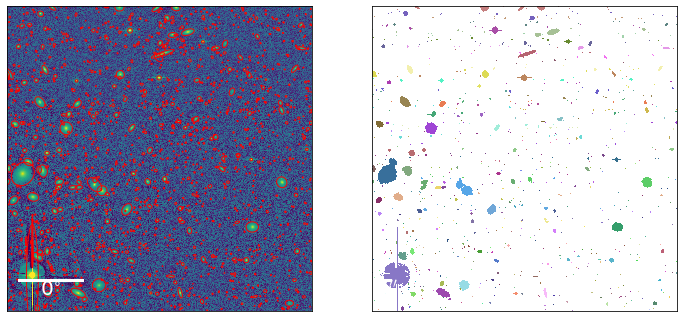

In [52]:
objects, segmap = extract_obj(hires_3, b=64, f=3, sigma=2.5, minarea=3, 
                              show_fig=True, flux_aper=[3, 6], 
                              deblend_nthresh=32, 
                              deblend_cont=5e-4)
objects.write('_hires_obj_cat.fits', format='fits', overwrite=True)

In [168]:
10**((24 - 27)/(-2.5)) * (2.5)**2

99.05582452881958

In [185]:
fluxmod = fits.open('_hires_fluxmod.fits')[0].data
kernel = fits.open('kernel_median.fits')[0].data
im_hires = fits.open('_df_model_3.0.fits')[0].data

E = fluxmod / im_hires
E *= np.sum(kernel)

In [186]:
ratio

array([0.        , 0.        , 0.26787074, ..., 0.13532615, 0.03410883,
       0.21426929])

In [187]:
flux = []
ratio = []
im_seg_ind = np.where(segmap>0)
im_seg_slice = segmap[im_seg_ind]
im_ratio = E
im_ratio_slice = im_ratio[im_seg_ind]
im_highres_slice = hires_3[im_seg_ind]

for obj in objects:
    ind = np.where(np.isin(im_seg_slice, obj['index']))
    flux_hires = im_highres_slice[ind]
    flux_ratio = im_ratio_slice[ind]
    flux.append(np.mean(flux_hires))
    ratio.append(np.mean(flux_ratio))
flux = np.array(flux)
ratio = np.array(ratio)
ratio = ratio[ratio != 0]

In [188]:
import matplotlib.pyplot as plt

In [197]:
np.sum(ratio > 1)

69

In [195]:
len(ratio)

436

(array([  4., 402.,  26.,   3.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-3.53421289, -0.75495052,  2.02431185,  4.80357421,  7.58283658,
        10.36209895, 13.14136132, 15.92062369, 18.69988606, 21.47914843,
        24.2584108 ]),
 <a list of 10 Patch objects>)

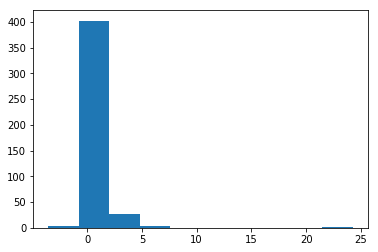

In [191]:
plt.hist(ratio[~np.isnan(ratio)])

In [140]:
E

0.37225615402184

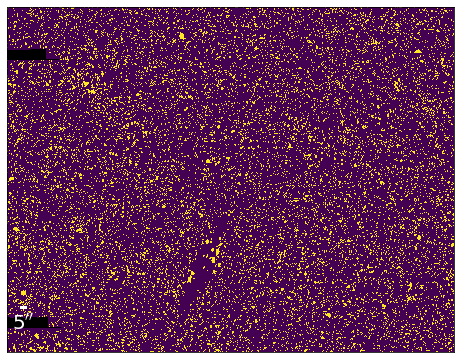

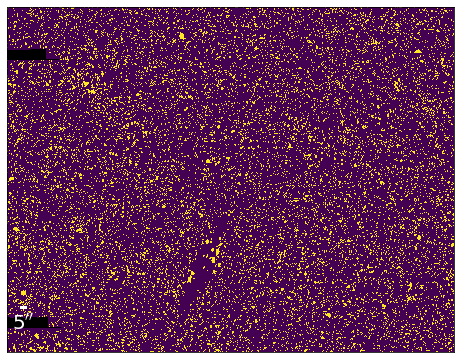

In [142]:
display_single(E)

In [86]:
from mrf.utils import mask_remove_obj, mask_out_certain_galaxy, seg_remove_obj

In [87]:
import copy

In [92]:
test = copy.deepcopy(segmap)
for obj in objects[np.where(mag < 17.5)]:
    test = seg_remove_obj(test, obj['x'], obj['y'])

In [93]:
ra = Column(data=[194.805008, 194.813726, 194.6502971, 194.6937727, 194.8177801], name='ra')
dec = Column(data=[27.97694499, 27.97054081, 27.87287833, 27.98150418, 27.89141156], name='dec')

In [94]:
Table([ra, dec]).write('./gal_cat.txt', format='ascii')

In [95]:
gal_cat = Table.read('./gal_cat.txt', format='ascii')

In [96]:
testest = mask_out_certain_galaxy(test, hdr, gal_cat=gal_cat)

### Removing object 0 from mask ###
### Removing object 638 from mask ###
### Removing object 1100 from mask ###
### Removing object 569 from mask ###
### Removing object 991 from mask ###


In [111]:
test = fits.open('_hires_fluxmod.fits')[0].data

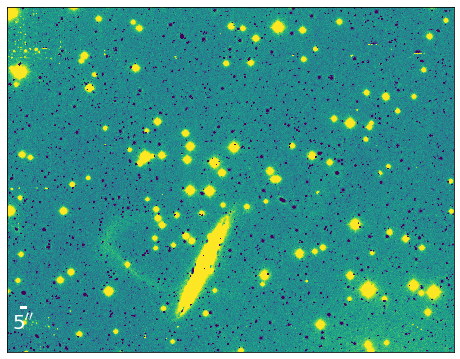

In [5]:
img = fits.open('./_res_3.0.fits')[0].data
display_single(img);

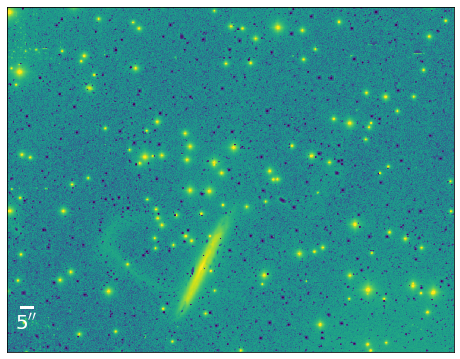

In [15]:
from mrf.utils import extract_obj
res = Celestial(fits.open('res.fits')[0].data, header=fits.open('res.fits')[0].header)
res.display_Celestial()

# Detect 267 objects


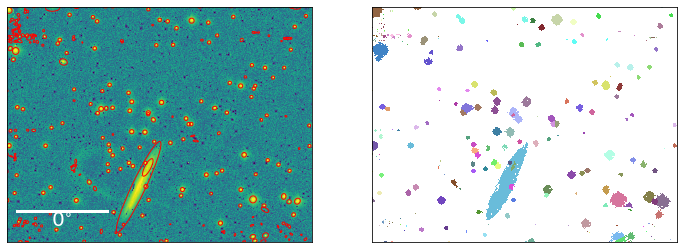

In [211]:
star_cat = Table.read('_bright_stars.fits')
star_cat['x'] /= 3
star_cat['y'] /= 3
ra, dec = res.wcs.wcs_pix2world(star_cat['x'], star_cat['y'], 0)
star_cat.add_columns([Column(data=ra, name='ra'), Column(data=dec, name='dec')])
#edge_mask = (psf_cat['x'] < res.shape[1] + 2 * halosize) & (psf_cat['x'] >  2 * halosize) & (psf_cat['y'] >  2 * halosize) & (psf_cat['y'] < res.shape[0] + 2 * halosize)



# Extract stars from image

objects, segmap = extract_obj(res.image.byteswap().newbyteorder(), 
                              b=64, f=3, sigma=4, minarea=5,
                              deblend_nthresh=32, 
                              deblend_cont=0.005, 
                              sky_subtract=False, show_fig=True, 
                              flux_aper=[3, 6])
ra, dec = res.wcs.wcs_pix2world(objects['x'], objects['y'], 0)
objects.add_columns([Column(data=ra, name='ra'), Column(data=dec, name='dec')])
# Match two catalogs
temp = match_coordinates_sky(SkyCoord(ra=star_cat['ra'], dec=star_cat['dec'], unit='deg'),
                             SkyCoord(ra=objects['ra'], dec=objects['dec'], unit='deg'))[0]
    
psf_cat = objects[np.unique(temp)]
psf_cat.sort('flux')
psf_cat.reverse()
mag = 27 - 2.5 * np.log10(psf_cat['flux'])
psf_cat.add_column(Column(data=mag, name='mag'))
bright_star_cat = psf_cat

In [116]:
from mrf.utils import save_to_fits

In [117]:
df_model = fits.open('./_df_model.fits')[0].data + fits.open('./df_halos.fits')[0].data
save_to_fits(df_model, 'df_model_halos.fits')

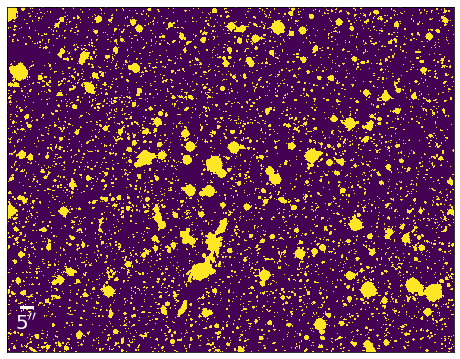

In [191]:
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
import copy
temp = (convolve(df_model, Gaussian2DKernel(1.5)))
model_mask = copy.deepcopy(temp)
model_mask[df_model < 7] = 0
model_mask[model_mask != 0] = 1
display_single(model_mask);

In [177]:
from mrf.utils import bright_star_mask

In [227]:
bright_star_cat.write('_bright_star_cat.fits', format='fits', overwrite=True)

In [ ]:
df_model = fits.open('df_model_halos.fits')[0].data


In [225]:
model_mask = convolve(df_model, Gaussian2DKernel(1.5))
model_mask[model_mask < 10] = 0
model_mask[model_mask != 0] = 1

totmask = bright_star_mask(model_mask.astype(bool), bright_star_cat,
                          bright_lim=15.5, r=8)
# strmask = convolve(strmask, Box2DKernel(10))
# Total mask with noise
totmask = convolve(totmask.astype(float), Box2DKernel(2))
totmask[totmask > 0] = 1

from mrf.utils import img_replace_with_noise
final_image = img_replace_with_noise(res.image.byteswap().newbyteorder(), totmask)


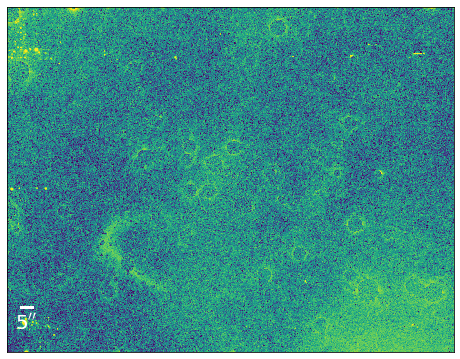

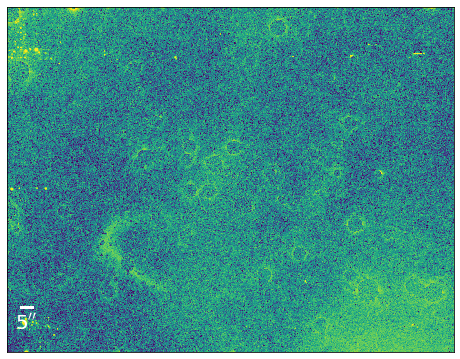

In [226]:
display_single(final_image)

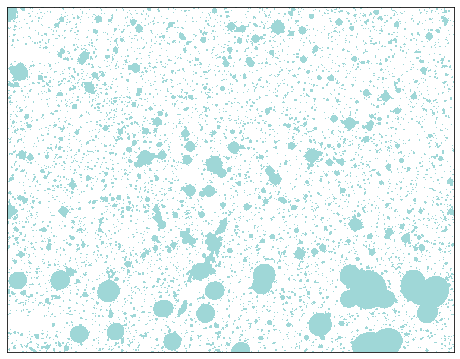

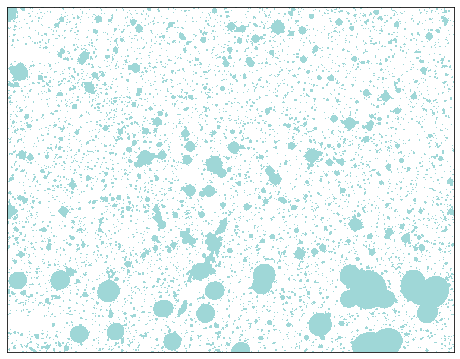

In [187]:
display_single(temp.astype(float), scale='linear', cmap=SEG_CMAP)

In [ ]:
sep.mask_ellipse()

In [36]:
temp = match_coordinates_sky(SkyCoord(ra=objects['ra'], dec=objects['dec'], unit='deg'),
                             SkyCoord(ra=star_cat['ra'], dec=star_cat['dec'], unit='deg'),)[0]
bright_star_cat = hstack([objects[temp] , star_cat[temp]], join_type='exact') # here's the final star catalog

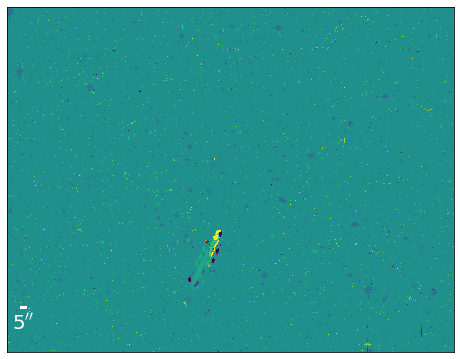

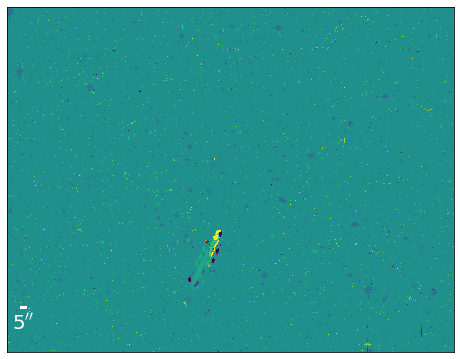

In [7]:
img = fits.open('_colcorrect.fits')[0].data
display_single(img)

In [12]:
hdu = fits.open('./df_field_r.fits')
df = Celestial(hdu[0].data, header=hdu[0].header)

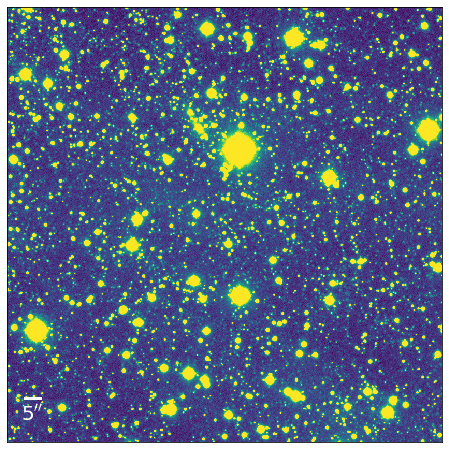

In [8]:
df.display_image()

In [9]:
df.resize_image(3, method='iraf')

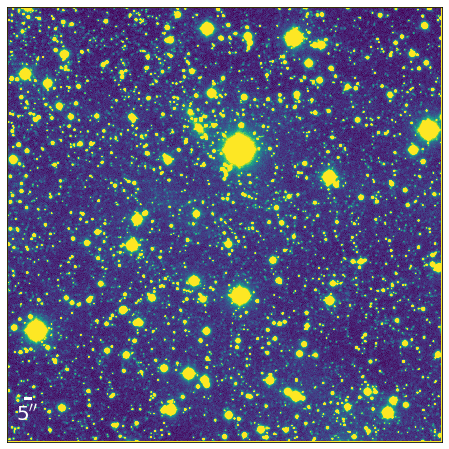

In [10]:
df.display_image()

In [13]:
df.image.shape

(840, 840)